# Base

In [29]:
import numpy as np
import pandas as pd
from scipy.stats import invgamma
import logging
import random
from typing import Dict, List
from itertools import combinations


pd.set_option("display.max_rows", None)

In [30]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger()


# Parameters

In [ ]:

samples_structure = {
    'number_of_samples': 2000,
    'number_of_batches': 3,
    'number_of_classes': 3,
    'proportion_of_samples_per_class': {
        'Class1': 0.4,
        'Class2': 0.3,
        'Class3': 0.3
    },
    'proportion_of_samples_per_batch': {
        'batch1': 0.4,
        'batch2': 0.3,
        'batch3': 0.3
    },
    'subclasses_per_class': {
        'Class1': ['sub1', 'sub2', 'sub3'],
        'Class2': ['sub4'],
        'Class3': ['sub5', 'sub6']
    },
    'proportion_of_samples_per_subclass': {
        'Class1': {'sub1': 0.3, 'sub2': 0.25, 'sub3': 0.45}, 
        'Class2': {'sub4': 1.0},        # 100% of samples in Class2 belong to subclass 'sub4'
        'Class3': {'sub5': 0.3, 'sub6': 0.7}
    },
    'subclasses_outside_classes': ['cov1', 'cov2'],
    'proportion_of_samples_per_subclasses_outside_classes': {
        'cov1': 0.2,
        'cov2': 0.1
        # samples not covered by cov will recieve NA values
    }
}

# to visualize the structure of the samples use mu > 10
# to simulate the structure of a real dataset use mu < 4

simulation_params = {
    'metadata': None,
    'random_state': 42,
    'features_total': 7000,
    'include_classes': True,
    'allow_partially_intersecting_classes': False,
    'include_subclasses': True,
    'allow_partially_intersecting_subclasses': True,
    'include_covariates': True,
    'features_per_class_params': {
        'Class1': {
            'DE': {'mu_up': 4, 'mu_down': 3},
            'number_of_proteins': 700
        },
        'Class2': {
            'DE': {'mu_up': 4, 'mu_down': 3.5},
            'number_of_proteins': 600
        },
        'Class3': {
            'DE': {'mu_up': 3, 'mu_down': 3.5},
            'number_of_proteins': 500
        }
    },
    'features_per_subclass_params': {       # if all belong to the same class, no need to specify subclass
        'Class1_sub1': {
            'DE': {'mu_up': 2.5, 'mu_down': 2.0},
            'number_of_proteins': 300
        },
        'Class1_sub2': {
            'DE': {'mu_up': 2.5, 'mu_down': 3.0},
            'number_of_proteins': 450
        },
        'Class1_sub3': {
            'DE': {'mu_up': 1.0, 'mu_down': 1.8},
            'number_of_proteins': 200
        },
        'Class3_sub5': {
            'DE': {'mu_up': 2, 'mu_down': 2.5},
            'number_of_proteins': 300
        },
        'Class3_sub6': {
            'DE': {'mu_up': 2.5, 'mu_down': 2},
            'number_of_proteins': 250
        }
    },
    'features_outside_classes_params': {
        'cov1': {
            'DE': {'mu_up':1.4, 'mu_down': 1.4},
            'number_of_proteins': 100
        },
        'cov2': {
            'DE': {'mu_up': 1.4, 'mu_down': 1.4},
            'number_of_proteins': 100
        }
    }
}

# Simulation

In [32]:

def generate_metadata_from_structure(samples_structure: Dict, random_state: int = 42) -> pd.DataFrame:
    """
    Generate metadata based on provided structure.
    """
    np.random.seed(random_state)
    random.seed(random_state)

    total_samples = samples_structure['number_of_samples']
    
    # List of proportion keys to validate
    proportion_keys = [
        'proportion_of_samples_per_class',
        'proportion_of_samples_per_batch',
        'proportion_of_samples_per_subclass',
        'proportion_of_samples_per_subclasses_outside_classes'  # Corrected spelling
    ]
    
    # Validate proportions
    for key in proportion_keys:
        if key in samples_structure:
            props = samples_structure[key]
            if isinstance(props, dict):
                if key == 'proportion_of_samples_per_subclass':
                    for cls, sub_props in props.items():
                        total = sum(sub_props.values())
                        if not np.isclose(total, 1.0):
                            raise ValueError(f"Subclass proportions for class '{cls}' sum to {total}, not 1.")
                elif key == 'proportion_of_samples_per_subclasses_outside_classes':
                    total = sum(props.values())
                    if total > 1.0 + 1e-8:  # Allow a small epsilon for floating point precision
                        raise ValueError(f"Proportions for '{key}' sum to {total}, which exceeds 1.")
                else:
                    total = sum(props.values())
                    if not np.isclose(total, 1.0):
                        raise ValueError(f"Proportions for '{key}' sum to {total}, not 1.")
            else:
                raise ValueError(f"Proportions for '{key}' should be a dictionary.")

    class_props = samples_structure['proportion_of_samples_per_class']
    batch_props = samples_structure['proportion_of_samples_per_batch']
    subclasses_dict = samples_structure.get('subclasses_per_class', {})
    subclass_props = samples_structure.get('proportion_of_samples_per_subclass', {})
    covariate_props = samples_structure.get('proportion_of_samples_per_subclasses_outside_classes', {})
    
    # Generate sample IDs
    sample_ids = [f'sample_{i+1}' for i in range(total_samples)]
    
    # Assign classes
    class_counts = {cls: int(round(prop * total_samples)) for cls, prop in class_props.items()}
    diff = total_samples - sum(class_counts.values())
    if diff != 0:
        first_class = list(class_counts.keys())[0]
        class_counts[first_class] += diff
    
    # Assign batches
    batch_counts = {b: int(round(prop * total_samples)) for b, prop in batch_props.items()}
    diff_b = total_samples - sum(batch_counts.values())
    if diff_b != 0:
        first_batch = list(batch_counts.keys())[0]
        batch_counts[first_batch] += diff_b
    
    metadata = pd.DataFrame({'sample_id': sample_ids})
    
    # Class assignment
    samples_assigned = 0
    for cls, count in class_counts.items():
        cls_indices = range(samples_assigned, samples_assigned + count)
        metadata.loc[cls_indices, 'class'] = cls
        samples_assigned += count
    
    # Batch assignment (shuffle)
    metadata = metadata.sample(frac=1, random_state=random_state).reset_index(drop=True)
    samples_assigned = 0
    for b, count in batch_counts.items():
        b_indices = range(samples_assigned, samples_assigned + count)
        metadata.loc[b_indices, 'batch'] = b
        samples_assigned += count
    metadata = metadata.sort_values('sample_id').reset_index(drop=True)
    
    # Subclass assignment with stricter randomization
    for cls in class_counts.keys():
        cls_mask = (metadata['class'] == cls)
        cls_subsamples = metadata[cls_mask]
        cls_subs = subclasses_dict.get(cls, [])
        total_cls_samples = len(cls_subsamples)
        if not cls_subs:
            metadata.loc[cls_mask, 'subclass'] = f"{cls}_sub1"
            continue

        sub_prop_dict = subclass_props.get(cls, None)
        if sub_prop_dict is None:
            even_prop = 1.0 / len(cls_subs)
            sub_prop_dict = {sb: even_prop for sb in cls_subs}
        else:
            # Normalize proportions (already validated to sum to 1.0)
            sub_prop_dict = {k: v for k, v in sub_prop_dict.items()}

        indices_for_class = cls_subsamples.index.tolist()
        random.shuffle(indices_for_class)  # Ensure proper shuffling
        start_idx = 0
        for sb in cls_subs:
            cnt = int(round(sub_prop_dict[sb] * total_cls_samples))
            sb_indices = indices_for_class[start_idx:start_idx + cnt]
            metadata.loc[sb_indices, 'subclass'] = f"{cls}_{sb}"
            start_idx += cnt

        # Assign remainder evenly across subclasses
        remainder = total_cls_samples - start_idx
        if remainder > 0:
            for i in range(remainder):
                metadata.loc[indices_for_class[start_idx + i], 'subclass'] = f"{cls}_{cls_subs[i % len(cls_subs)]}"
    
    # Covariates assignment
    metadata['covariate'] = None
    cov_counts = {c: int(round(p * total_samples)) for c, p in covariate_props.items()}
    sum_cov = sum(cov_counts.values())

    if sum_cov > total_samples:
        raise ValueError(f"Total covariate proportions exceed number of samples: {sum_cov} > {total_samples}")

    all_indices = metadata.index.tolist()
    random.shuffle(all_indices)
    start_idx = 0
    for c, cnt in cov_counts.items():
        if start_idx + cnt > total_samples:
            raise ValueError(f"Not enough samples to assign covariate {c}")
        cov_indices = all_indices[start_idx:start_idx + cnt]
        metadata.loc[cov_indices, 'covariate'] = c
        start_idx += cnt

    return metadata


def assign_features_without_intersection(entities: List[str], entity_params: Dict[str, Dict], 
                                         all_proteins: List[str], start_idx: int) -> (Dict[str, List[str]], int):
    """
    Assign distinct blocks of features to each entity without intersection.
    """
    assigned = {}
    current_start = start_idx
    for ent in entities:
        n_prot = entity_params[ent]['number_of_proteins']
        block = all_proteins[current_start:current_start+n_prot]
        assigned[ent] = block
        current_start += n_prot
    return assigned, current_start


def introduce_intersections(assigned: Dict[str, List[str]], entity_params: Dict[str, Dict], 
                            intersect_percent: float, rng: np.random.Generator):
    """
    Introduce intersections among all pairs of entities if allowed.
    Intersection logic:
    - For every pair of distinct entities (A,B):
      intersection_size = round(intersect_percent * (number_of_proteins(A)+number_of_proteins(B)))
      Randomly choose intersection_size features from entity A (or B) and add them to the other entity's set.
    """
    entities = list(assigned.keys())
    for (e1, e2) in combinations(entities, 2):
        n1 = entity_params[e1]['number_of_proteins']
        n2 = entity_params[e2]['number_of_proteins']
        total_for_pair = n1 + n2
        intersection_size = int(round(intersect_percent * total_for_pair))
        if intersection_size > 0:
            from_set = assigned[e1]
            chosen = rng.choice(from_set, size=intersection_size, replace=False)
            # Shuffle chosen features to avoid clustering bias
            chosen = list(chosen)
            rng.shuffle(chosen)
            set_e2 = set(assigned[e2])
            set_e2.update(chosen)
            assigned[e2] = list(set_e2)
    return assigned



def simulate_data(simulation_params: Dict) -> pd.DataFrame:
    """
    Updated intersection logic:
    1. Assign features to classes (no intersection).
    2. If class intersection allowed, introduce intersection among all pairs of classes.
    3. Assign features to subclasses (no intersection).
    4. If subclass intersection allowed, introduce intersection among all pairs of subclasses.
    5. Assign features to covariates (no intersection).
    6. Apply DE as before.

    Returns:
        expression_matrix (pd.DataFrame): Simulated expression data.
        assignments (Dict): Feature assignments for classes, subclasses, and covariates.
    """
    metadata_df = simulation_params['metadata']
    random_state = simulation_params.get('random_state', 42)
    features_total = simulation_params['features_total']

    include_classes = simulation_params.get('include_classes', True)
    include_subclasses = simulation_params.get('include_subclasses', True)
    include_covariates = simulation_params.get('include_covariates', True)

    class_params = simulation_params['features_per_class_params']
    subclass_params = simulation_params['features_per_subclass_params']
    covar_params = simulation_params['features_outside_classes_params']

    allow_class_intersect = simulation_params.get('allow_partially_intersecting_classes', False)
    allow_subclass_intersect = simulation_params.get('allow_partially_intersecting_subclasses', False)

    # Calculate total requested DE features
    class_de_sum = sum(p['number_of_proteins'] for p in class_params.values()) if include_classes else 0
    subclass_de_sum = sum(p['number_of_proteins'] for p in subclass_params.values()) if include_subclasses else 0
    covar_de_sum = sum(p['number_of_proteins'] for p in covar_params.values()) if include_covariates else 0
    total_requested_de = class_de_sum + subclass_de_sum + covar_de_sum
    if not (allow_class_intersect or allow_subclass_intersect) and total_requested_de > features_total:
        raise ValueError("Requested DE features exceed total features without intersection allowed.")

    np.random.seed(random_state)
    rng = np.random.default_rng(random_state)
    all_proteins = [f'protein_{i+1}' for i in range(features_total)]
    rng.shuffle(all_proteins)

    current_index = 0
    class_feature_sets = {}
    subclass_feature_sets = {}
    covar_feature_sets = {}
    class_intersect_percent = 0.15 if allow_class_intersect else 0.0
    subclass_intersect_percent = 0.15 if allow_subclass_intersect else 0.0

    # Assign classes
    if include_classes and len(class_params) > 0:
        class_names = list(class_params.keys())
        class_assigned, current_index = assign_features_without_intersection(
            class_names, class_params, all_proteins, current_index
        )
        if allow_class_intersect and len(class_names) > 1:
            class_assigned = introduce_intersections(class_assigned, class_params, class_intersect_percent, rng)
        class_feature_sets = class_assigned

    # Assign subclasses
    if include_subclasses and len(subclass_params) > 0:
        subclass_names = list(subclass_params.keys())
        subclass_assigned, current_index = assign_features_without_intersection(
            subclass_names, subclass_params, all_proteins, current_index
        )
        if allow_subclass_intersect and len(subclass_names) > 1:
            subclass_assigned = introduce_intersections(subclass_assigned, subclass_params, subclass_intersect_percent, rng)
        subclass_feature_sets = subclass_assigned

    # Assign covariates (no intersection by default)
    if include_covariates and len(covar_params) > 0:
        covar_names = list(covar_params.keys())
        covar_assigned, current_index = assign_features_without_intersection(
            covar_names, covar_params, all_proteins, current_index
        )
        covar_feature_sets = covar_assigned

    if current_index > features_total:
        raise ValueError("Assigned more features than total available.")

    # Convert all assigned lists to sets to ensure uniqueness after intersection
    class_feature_sets = {k: set(v) for k, v in class_feature_sets.items()}
    subclass_feature_sets = {k: set(v) for k, v in subclass_feature_sets.items()}
    covar_feature_sets = {k: set(v) for k, v in covar_feature_sets.items()}

    # Create baseline
    m = metadata_df.shape[0]

    #approach from https://academic.oup.com/bioinformatics/article/37/6/815/5938077
    mu_00 = np.random.normal(0, 1, features_total)
    var_00 = invgamma.rvs(a=5, scale=2, size=features_total)
    expression_matrix = pd.DataFrame(
        np.random.normal(
            loc=np.outer(mu_00, np.ones(m)),  # Mean vector for each feature
            scale=np.sqrt(np.outer(var_00, np.ones(m)))  # Standard deviation vector for each feature
        ),
        index=all_proteins,
        columns=[f'sample_{i + 1}' for i in range(m)]
    )
    
    def apply_entity_de(features, mu_up, mu_down, sample_ids):
        if len(features) == 0 or (mu_up == 0 and mu_down == 0):
            return
        n = len(features)
        # Determine up and down splits
        if mu_up > 0 and mu_down > 0:
            half = n // 2
            up_features = features[:half]
            down_features = features[half:]
        elif mu_up > 0 and mu_down == 0:
            up_features = features
            down_features = []
        elif mu_down > 0 and mu_up == 0:
            down_features = features
            up_features = []
        else:
            return

        # Apply up
        if len(up_features) > 0:
            for feature in up_features:
                num_up_samples = rng.binomial(len(sample_ids), 0.8)
                if num_up_samples > 0:
                    up_sample_subset = rng.choice(sample_ids, size=num_up_samples, replace=False)
                    random_multipliers = rng.uniform(0.3, 1.0, size=num_up_samples)  # Random values between 0.3 and 1.0
                    expression_matrix.loc[feature, up_sample_subset] += mu_up * random_multipliers

        # Apply down
        if len(down_features) > 0:
            for feature in down_features:
                num_down_samples = rng.binomial(len(sample_ids), 0.8)
                if num_down_samples > 0:
                    down_sample_subset = rng.choice(sample_ids, size=num_down_samples, replace=False)
                    random_multipliers = rng.uniform(0.3, 1.0, size=num_down_samples)  # Random values between 0.3 and 1.0
                    expression_matrix.loc[feature, down_sample_subset] -= mu_down * random_multipliers


    # Apply DE to classes
    if include_classes:
        for cls, p in class_params.items():
            class_mask = (metadata_df['class'] == cls)
            class_samples = metadata_df.loc[class_mask, 'sample_id'].values
            mu_up = p['DE']['mu_up']
            mu_down = p['DE']['mu_down']
            apply_entity_de(list(class_feature_sets[cls]), mu_up, mu_down, class_samples)

    # Apply DE to subclasses
    if include_subclasses:
        for sbcl, p in subclass_params.items():
            sbcl_mask = (metadata_df['subclass'] == sbcl)
            sbcl_samples = metadata_df.loc[sbcl_mask, 'sample_id'].values
            mu_up = p['DE']['mu_up']
            mu_down = p['DE']['mu_down']
            apply_entity_de(list(subclass_feature_sets[sbcl]), mu_up, mu_down, sbcl_samples)

    # Apply DE to covariates
    if include_covariates:
        for cov, p in covar_params.items():
            cov_mask = (metadata_df['covariate'] == cov)
            cov_samples = metadata_df.loc[cov_mask, 'sample_id'].values
            mu_up = p['DE']['mu_up']
            mu_down = p['DE']['mu_down']
            apply_entity_de(list(covar_feature_sets[cov]), mu_up, mu_down, cov_samples)

    assignments = {
        'classes': class_feature_sets,
        'subclasses': subclass_feature_sets,
        'covariates': covar_feature_sets
    }

    return expression_matrix, assignments



# Run and check

In [33]:
### Run the process

# 1. Generate metadata from samples_structure
metadata = generate_metadata_from_structure(samples_structure, random_state=42)
logger.info(f"Generated metadata:\n{metadata.head()}")

# 2. Assign generated metadata to simulation_params
simulation_params['metadata'] = metadata

# 3. Simulate data
simulated_data, assignments = simulate_data(simulation_params)  # Unpack the tuple
logger.info(f"Simulated data shape: {simulated_data.shape}")


Generated metadata:
     sample_id   class   batch     subclass covariate
0     sample_1  Class1  batch2  Class1_sub3      cov2
1    sample_10  Class1  batch2  Class1_sub2      cov1
2   sample_100  Class1  batch1  Class1_sub3      cov2
3  sample_1000  Class2  batch1  Class2_sub4      cov1
4  sample_1001  Class2  batch2  Class2_sub4      None
Simulated data shape: (7000, 2000)


<Axes: title={'center': 'Class Distribution by Subclass'}, xlabel='class'>

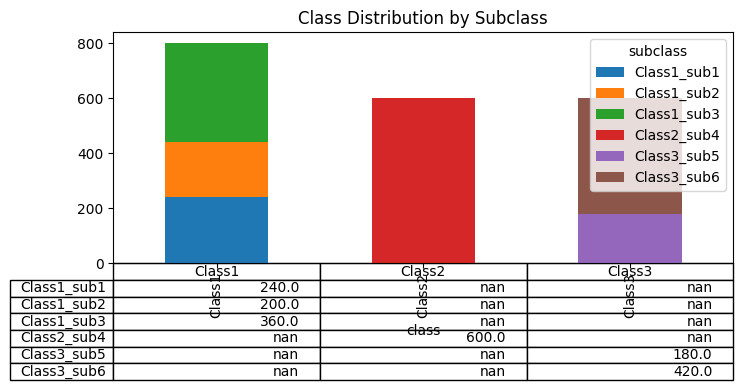

In [34]:

# Plot class distribution by subclass
metadata.groupby(['class', 'subclass']).size().unstack().plot(
    kind='bar', stacked=True, figsize=(8, 3), title='Class Distribution by Subclass',
    table=True
)

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

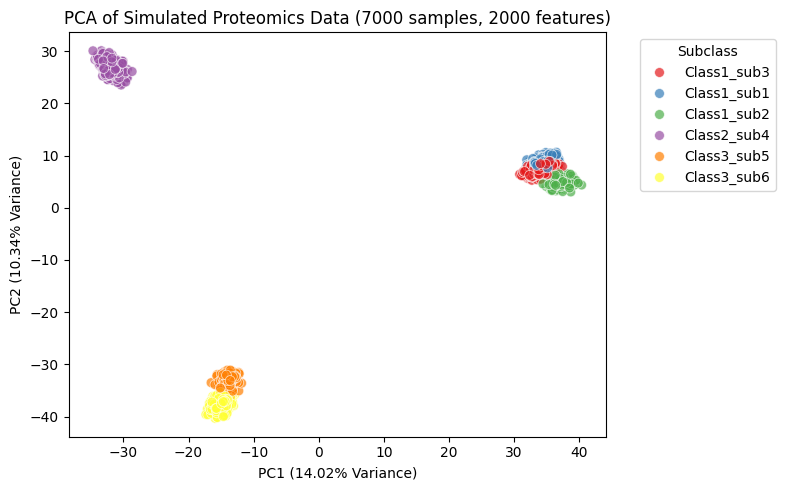

In [36]:
# Extract the subset of data
data_subset = simulated_data #.loc[sampled_genes, sampled_samples]

# Transpose for PCA: samples as rows, genes as features
data_for_pca = data_subset.transpose()

# Perform PCA
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(data_for_pca)

# Create a DataFrame with PCA results and metadata
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['sample'] = data_for_pca.index
# Merge with metadata to get subclass information
pca_df = pca_df.merge(metadata[['sample_id', 'subclass']], left_on='sample', right_on='sample_id')

# Plot PCA
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='subclass',
    palette='Set1',
    data=pca_df,
    s=50,
    alpha=0.7
)
plt.title(f'PCA of Simulated Proteomics Data ({data_subset.shape[0]} samples, {data_subset.shape[1]} features)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.legend(title='Subclass', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [37]:
# Step 1: Sort the metadata and data based on 'class' and 'subclass'
sorted_metadata = metadata.sort_values(['subclass'])
sorted_metadata.index = sorted_metadata['sample_id']
sorted_samples = sorted_metadata['sample_id'].values
data_subset_sorted = simulated_data.loc[:, sorted_samples]

# Step 2: Generate automatic color mappings for 'class' and 'subclass'
# Using Seaborn's color palettes without specifying exact colors
unique_classes = sorted_metadata['class'].unique()
unique_subclasses = sorted_metadata['subclass'].unique()

# Create color palettes
class_palette = sns.color_palette("tab10", n_colors=len(unique_classes))
subclass_palette = sns.color_palette("husl", n_colors=len(unique_subclasses))

# Create mappings
class_lut = dict(zip(unique_classes, class_palette))
subclass_lut = dict(zip(unique_subclasses, subclass_palette))

# Step 3: Create the `col_colors` DataFrame
col_colors = pd.DataFrame({
    'Class': sorted_metadata['class'].map(class_lut),
    'Subclass': sorted_metadata['subclass'].map(subclass_lut)
}, index=sorted_samples).loc[sorted_samples, :]

# # Step 4: Plot the clustermap with `col_colors`
# sns.clustermap(
#     data_subset_sorted,
#     col_colors=col_colors,
#     row_cluster=True,    # Set to True if you want to cluster 
#     col_cluster=False,     # Set to False if you don't want to cluster 
#     figsize=(15, 10),
#     xticklabels=False,
#     yticklabels=False,
#     cmap='vlag'
# )

# plt.suptitle('Simulated Proteomics Data Heatmap', y=1.02, fontsize=16)
# plt.tight_layout()
# plt.show()

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Step 0: Z-score the data (row-wise)
# This normalizes each feature across all samples
data_subset_zscored = simulated_data.copy().loc[:,sorted_samples]
data_subset_zscored = data_subset_zscored.apply(zscore, axis=1)

# Handle any NaN values resulting from constant rows (std=0)
data_subset_zscored = data_subset_zscored.fillna(0)

# # Step 4: Plot the clustermap with `col_colors`
# clustermap = sns.clustermap(
#     data_subset_zscored,
#     col_colors=col_colors,
#     row_cluster=True,    # Cluster rows (features)
#     col_cluster=False,   # Do not cluster columns (samples)
#     figsize=(15, 10),
#     xticklabels=False,
#     yticklabels=False,
#     cmap='vlag',         # Diverging color palette
#     standard_scale=None, # Data is already z-scored
# )

# plt.suptitle('Z-Scored Simulated Proteomics Data Heatmap', y=1.02, fontsize=16)
# plt.tight_layout()
# plt.show()


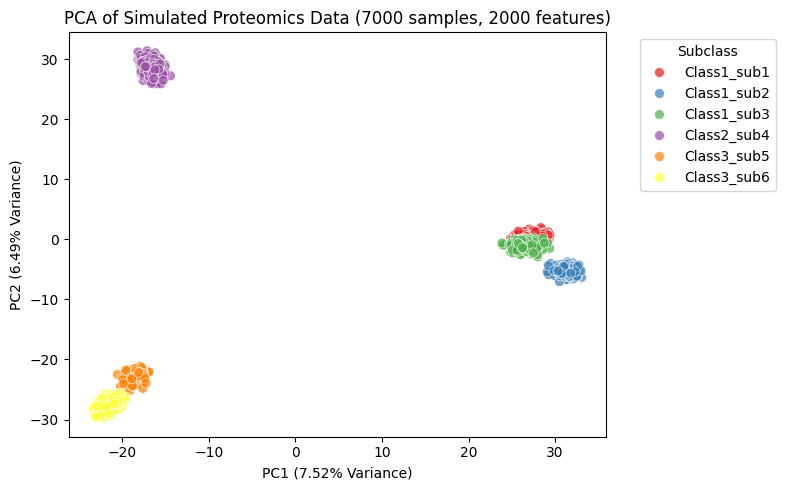

In [39]:
# Transpose for PCA: samples as rows, genes as features
data_for_pca = data_subset_zscored.transpose()

# Perform PCA
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(data_for_pca)

# Create a DataFrame with PCA results and metadata
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['sample'] = data_for_pca.index
# Merge with metadata to get subclass information
pca_df = pca_df.merge(metadata[['sample_id', 'subclass']], left_on='sample', right_on='sample_id')

# Plot PCA
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='subclass',
    palette='Set1',
    data=pca_df,
    s=50,
    alpha=0.7
)
plt.title(f'PCA of Simulated Proteomics Data ({data_subset_zscored.shape[0]} samples, {data_subset_zscored.shape[1]} features)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.legend(title='Subclass', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

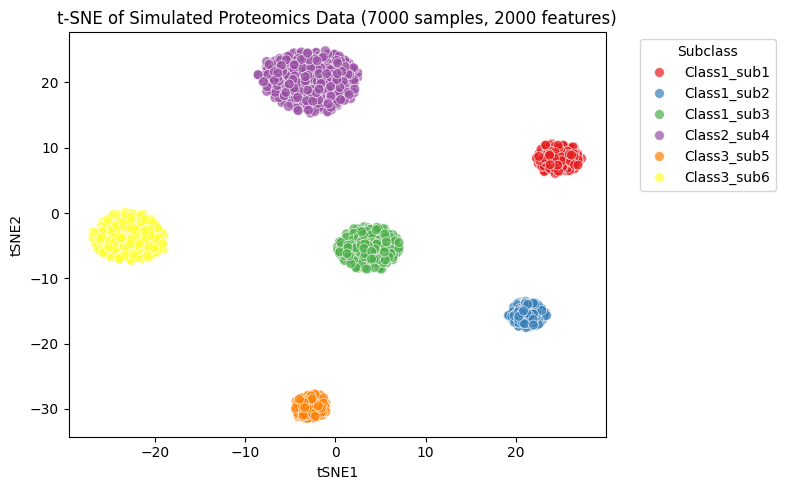

In [42]:
from sklearn.manifold import TSNE

# Transpose for t-SNE: samples as rows, genes as features
data_for_tsne = data_subset_zscored.transpose()

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(data_for_tsne)

# Create a DataFrame with t-SNE results and metadata
tsne_df = pd.DataFrame(data=tsne_results, columns=['tSNE1', 'tSNE2'])
tsne_df['sample'] = data_for_tsne.index
# Merge with metadata to get subclass information
tsne_df = tsne_df.merge(metadata[['sample_id', 'subclass']], left_on='sample', right_on='sample_id')

# Plot t-SNE
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x='tSNE1', y='tSNE2',
    hue='subclass',
    palette='Set1',
    data=tsne_df,
    s=50,
    alpha=0.7
)
plt.title(f't-SNE of Simulated Proteomics Data ({data_subset_zscored.shape[0]} samples, {data_subset_zscored.shape[1]} features)')
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.legend(title='Subclass', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# SAve

In [40]:
# save the data
metadata.to_csv('metadata.csv', index=False)
simulated_data.to_csv('simulated_data.csv', index='protein')
data_subset_zscored.to_csv('simulated_data_zscored.csv', index='protein')